# Speech Feature Extraction using MFCC

In [1]:
import numpy 
import sounddevice as sd
import scipy.io.wavfile as wf
from scipy.fftpack import dct
import matplotlib.pyplot as plt

%matplotlib inline

## Load Speech Data

Speech Data is loaded in .wav files as that is most lossless compression format

In [2]:
sample_rate, signal=wf.read('./data/Recording.wav')

In [3]:
sample_rate

48000

In [4]:
len(signal)

328704

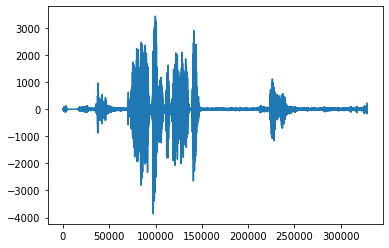

In [5]:
plt.plot(signal[:,0])

In [6]:
signal.shape

(328704, 2)

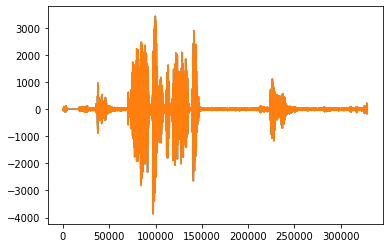

In [7]:
plt.plot(signal)

In [8]:
sd.play(signal)

## Pre-Emphasis

Pre-emphasis. Usually speech signal is pre-emphasized before any further processing. By looking at the spectrum of voiced segments we can see that the energy in the voice samples distributes more in the lower frequencies than in the higher frequencies.

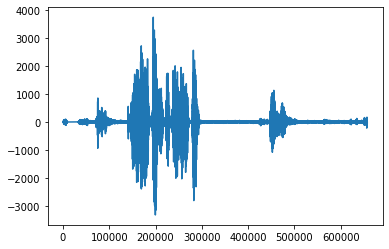

In [9]:
pre_emphasis=0.97
emphasized_signal=numpy.append(signal[0],signal[1]-pre_emphasis*signal[:-1])
plt.plot(emphasized_signal)

In [10]:
emphasized_signal.shape

(657408,)

## Framing

Frame blocking or framing is a fundamental signal processing technique that consists of dividing the original signal into #F blocks often called frames with length Nf an overlap M and a framing hop H(H=Nf−M). Overlapping the frames help avoiding information loss in between adjacent frames.

In [11]:
frame_size=0.025
frame_stride=0.01

# Convert from seconds to samples
frame_length, frame_step=frame_size*sample_rate, frame_stride*sample_rate

In [12]:
signal_length=len(emphasized_signal)
frame_length=int(round(frame_length))
frame_step=int(round(frame_step))
print(frame_step, frame_length)

480 1200


In [13]:
num_frames=int(numpy.ceil(float(numpy.abs(signal_length-frame_length))/frame_step))
print(num_frames)

1368


In [14]:
pad_signal_length=num_frames*frame_step+frame_length
z=numpy.zeros((pad_signal_length-signal_length))
pad_signal=numpy.append(emphasized_signal,z)

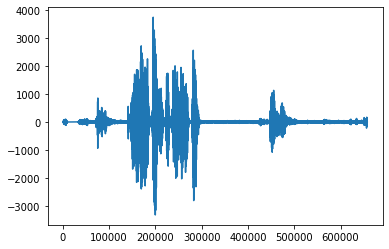

In [15]:
plt.plot(pad_signal)

In [16]:
indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, 
                num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]
frames.shape

(1368, 1200)

## Windowing

In [17]:
frames *= numpy.hamming(frame_length)
frames.shape

(1368, 1200)

## Fourier-Transform and Power Spectrum

In [18]:
NFFT = 512 # or 256
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

## Filter Banks

In [19]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

## Mel-frequency Cepstral Coefficients (MFCCs)

In [20]:
num_ceps = 12
cep_lifter = 22 #refers to the dimensionality of the MFCC vector in the original formulation.

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift

## Mean Normalization

In [21]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)